In [1]:
import pandas as pd

In [2]:
## DATA FORM REFERENCE

DATA_PATH = '../Obesity-Prediction/data/train.csv'

df = pd.read_csv(DATA_PATH)
df = df.drop('id', axis=1)
print(f'Sample size: {len(df)}, Data shape: {df.shape}')
df.head()

Sample size: 20758, Data shape: (20758, 17)


,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Male,24.443011,1.699998,81.669950,yes,yes,2.000000,2.983297,Sometimes,no,2.763573,no,0.000000,0.976473,Sometimes,Public_Transportation,Overweight_Level_II
1,Female,18.000000,1.560000,57.000000,yes,yes,2.000000,3.000000,Frequently,no,2.000000,no,1.000000,1.000000,no,Automobile,Normal_Weight
2,Female,18.000000,1.711460,50.165754,yes,yes,1.880534,1.411685,Sometimes,no,1.910378,no,0.866045,1.673584,no,Public_Transportation,Insufficient_Weight
3,Female,20.952737,1.710730,131.274851,yes,yes,3.000000,3.000000,Sometimes,no,1.674061,no,1.467863,0.780199,Sometimes,Public_Transportation,Obesity_Type_III
4,Male,31.641081,1.914186,93.798055,yes,yes,2.679664,1.971472,Sometimes,no,1.979848,no,1.967973,0.931721,Sometimes,Public_Transportation,Overweight_Level_II


In [141]:
import pandas as pd
import requests
from io import BytesIO

url_list = {
    'Demographic Variables': 'https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/2021/DataFiles/DEMO_L.xpt',
    'Total Nutrient Intakes, First Day': 'https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/2021/DataFiles/DR1TOT_L.xpt',
    'Body Measures': 'https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/2021/DataFiles/BMX_L.xpt',
    'Individual Foods, First Day': 'https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/2021/DataFiles/DR1IFF_L.xpt',
    'Cigarette Use': 'https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/2017/DataFiles/P_SMQ.xpt',
    'Physical Activity': 'https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/2017/DataFiles/P_PAQ.xpt',
    'Alcohol Use': 'https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/2017/DataFiles/P_ALQ.xpt',
    'Plasma Fasting': 'https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/2017/DataFiles/P_GLU.xpt',
    'Diabetes': 'https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/2017/DataFiles/P_DIQ.xpt',
}

df = pd.DataFrame()

for dataset_name, url in url_list.items():
    response = requests.get(url)
    if response.status_code == 200:
        xpt_data = pd.read_sas(BytesIO(response.content), format='xport')

        if 'DR1ILINE' in xpt_data:
            valid_meals = [1, 2, 3] # Breakfast, Lunch, Dinner Code
            valid_meals_df = xpt_data[xpt_data['DR1_030Z'].isin(valid_meals)]
            between_meals_df = xpt_data[~xpt_data['DR1_030Z'].isin(valid_meals)]

            # - - - - - NCP: Count the number of meals per participant - - - - - #
            valid_meal_count_df = valid_meals_df.groupby('SEQN').apply(
                lambda x: x[['DR1_020', 'DR1_030Z']].drop_duplicates().shape[0]
            ).reset_index(name='NCP')

            # - - - - - CAEC: Count the meals between main meals per participant? - - - - - #
            between_meal_count_df = valid_meals_df.groupby('SEQN').apply(
                lambda x: x[['DR1_020', 'DR1_030Z']].drop_duplicates().shape[0]
            ).reset_index(name='CAEC')   

            # - - - - - FCVC: Count meals with vegetables per participant - - - - - #
            valid_meals_df['is_vegetable'] = valid_meals_df['DR1IFDCD'].astype(str).str.startswith('7')
            veg_meals_df = (
                valid_meals_df[valid_meals_df['is_vegetable']]
                .groupby(['SEQN', 'DR1_030Z'])  # Group by participant and meal type
                .size()
                .reset_index(name='VegMealCount')
                .groupby('SEQN')  # Aggregate total vegetable meals per participant
                .size()
                .reset_index(name='FCVC')
            )            

            # Merge all dataframes
            merged_daily_food = (
                valid_meal_count_df
                .merge(between_meal_count_df, on='SEQN', how='left')
                .merge(veg_meals_df, on='SEQN', how='left')
            )

            xpt_data = merged_daily_food

        # Merge on SEQN if df already contains data
        if df.empty:
            df = xpt_data
        else:
            df = pd.merge(df, xpt_data, on='SEQN', how='outer')
        print(f'{dataset_name:<40}:{xpt_data.shape}')
    else:
        print(f"Failed to load {url}. Status code: {response.status_code}")

meal_count_columns = ['NCP', 'CAEC', 'FCVC']
df[meal_count_columns] = df[meal_count_columns].fillna(0).astype(int)
df['Gender'] = df['RIAGENDR'].fillna(0).astype(int)                       # Can't drop (otherwise important feature being null)
df['Age'] = df['RIDAGEYR'].fillna(df['RIDAGEYR'].mean()).astype(int)   # Can't drop (otherwise important feature being null)

# - - - - - Weight & Height: Extract weight (kg) and height (m) - - - - - #
if 'BMXWT' in df and 'BMXHT' in df:
    mean_weight = df['BMXWT'].mean()
    mean_height = df['BMXHT'].mean()
    df['Weight'] = df['BMXWT'].fillna(mean_weight).astype(float)
    df['Height'] = df['BMXHT'].fillna(mean_weight).astype(float)
    df['Height'] = df['Height'] / 100

# - - - - - FAVC: Eat high caloric food frequently? - - - - - #
if 'DR1TKCAL' in df:
    mean_kcal = df['DR1TKCAL'].mean()
    mean_kcal_male = df[df['RIAGENDR'] == 1]['DR1TKCAL'].mean()  # Mean for males
    mean_kcal_female = df[df['RIAGENDR'] == 2]['DR1TKCAL'].mean()  # Mean for females
    df['FAVC'] = df.apply(
        lambda row: mean_kcal_male if row['RIAGENDR'] == 1 and pd.isnull(row['DR1TKCAL']) else (
                    mean_kcal_female if row['RIAGENDR'] == 2 and pd.isnull(row['DR1TKCAL']) else (
                    mean_kcal if pd.isnull(row['DR1TKCAL']) else row['DR1TKCAL'])),
        axis=1
    )

# - - - - - SMOKE: Smoked ≥100 cigarettes AND currently smokes - - - - - #
def is_smoker(row):
    if row['SMQ020'] == 1 and row['SMQ040'] in [1, 2]:
        return 1
    else:
        return 0
if 'SMQ020' in df and 'SMQ040' in df:
    df['SMOKE'] = df.apply(is_smoker, axis=1)

# - - - - - CH2O: Total water drink daily in litre - - - - - #
water_cols = ['DR1_330Z', 'DR1_320Z', 'DR1BWATZ']
if all(col in df.columns for col in water_cols):
    df['CH2O'] = df[water_cols].sum(axis=1) / 1000
    df['CH2O'] = df['CH2O'].fillna(df['CH2O'].mean()).astype(float)

# - - - - - FAF: Physical activity daily in hour - - - - - #
activity_cols = ['PAD615', 'PAD630', 'PAD645', 'PAD660', 'PAD675']
if all(col in df.columns for col in activity_cols):
    df['FAF'] = df[activity_cols].sum(axis=1) / 60
    mean_total_activity = df['FAF'].mean()
    df['FAF'] = df['FAF'].fillna(mean_total_activity).astype(float)

# - - - - - CALC: Drink alcohol frequency - - - - - #
if 'ALQ121' in df:
    df['ALQ121'] = df['ALQ121'].fillna(0)
    df['CALC'] = df['ALQ121'].astype(int)
    def categorize_alcohol(row):
        if row in [6, 7, 9, 10]:
            return 1
        elif row in [1, 2, 3, 4, 5, 8]:
            return 2
        else:
            return 0
    df['CALC'] = df['CALC'].apply(categorize_alcohol)
    df['CALC'] = df['CALC'].fillna(0)

print(df.shape)

Demographic Variables                   :(11933, 27)
Total Nutrient Intakes, First Day       :(8860, 168)
Body Measures                           :(8860, 22)


/var/folders/hf/tkmmlf9541b3ztty6czqx3q40000gn/T/ipykernel_79093/3439059892.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_meals_df['is_vegetable'] = valid_meals_df['DR1IFDCD'].astype(str).str.startswith('7')


Individual Foods, First Day             :(6182, 4)
Cigarette Use                           :(11137, 16)
Physical Activity                       :(9693, 17)
Alcohol Use                             :(8965, 10)
Plasma Fasting                          :(5090, 4)
Diabetes                                :(14986, 28)
(26919, 297)


## Definitions of Diabetes in NHANES

Diabetes is defined using two criteria:

1. **Fasting Plasma Glucose (FPG)** : ≥126 mg/dL (7.0 mmol/L) .
2. **Self-reported diagnosis** : Participants answering "yes" to questions like:
"Other than during pregnancy, have you ever been told you have diabetes?" .
"Have you ever been told you have diabetes?" (NHANES questionnaire)

In [142]:
def define_diabetes(row):
    if row['DIQ010'] == 1:
        return 1
    elif (row['LBXGLU'] >= 126):
        return 1
    else:
        return 0
df['Diabetes'] = df.apply(define_diabetes, axis=1)

## Construct sub dataframe

In [172]:
expected_columns = [
    'Gender', 'Age', 'Height', 'Weight', 'family_history_with_overweight',
    'FAVC', 'FCVC', 'NCP', 'CAEC', 'SMOKE', 'CH2O', 'SCC', 'FAF', 
    'TUE', 'CALC', 'MTRANS', 'Diabetes'
]

# Check if all expected columns are in the renamed DataFrame
missing_columns = [col for col in expected_columns if col not in df.columns]

if not missing_columns:
    print("All expected columns are present.")
else:
    print(f"Missing columns: {', '.join(missing_columns)}")

# Construct sub dataframe
sub_df = df[[col for col in expected_columns if col not in missing_columns]]
print(f'Sub Columns: {list(sub_df.columns)}')
display(sub_df.head())

null_columns_exist = sub_df.isnull().any().any()
na_columns_exist = sub_df.isna().any().any()
print(null_columns_exist)
print(na_columns_exist)

Missing columns: family_history_with_overweight, SCC, TUE, MTRANS
Sub Columns: ['Gender', 'Age', 'Height', 'Weight', 'FAVC', 'FCVC', 'NCP', 'CAEC', 'SMOKE', 'CH2O', 'FAF', 'CALC', 'Diabetes']


,Gender,Age,Height,Weight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,FAF,CALC,Diabetes
0,1,43,1.79500,86.9,1740.0,1,3,3,0,2.160000e+00,0.0,0,0
1,1,66,1.74200,101.8,2741.0,2,3,3,0,1.619282e-81,0.0,0,0
2,2,44,1.52900,69.4,1995.0,1,4,4,0,5.070000e+00,0.0,0,0
3,2,5,1.20100,34.3,1676.0,1,3,3,0,4.800000e-01,0.0,0,0
4,1,2,0.70549,13.6,1222.0,1,3,3,0,1.680000e+00,0.0,0,0


False
False


- Gender (0: Unknown, 1: Male, 2: Female)
- FAVC (Calories intake per day)
- FCVC (Number of main meals contains vegetables)
- CALC (0: Never drink alcohol, 1: Sometimes, 2: Frequent)
- Diabetes (0: True, 1: False)

# Diabetes Model Development
## Data Processing


In [300]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

from imblearn.combine import SMOTEENN
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import AUC


Resampled class distribution: {0: 17510, 1: 2507}


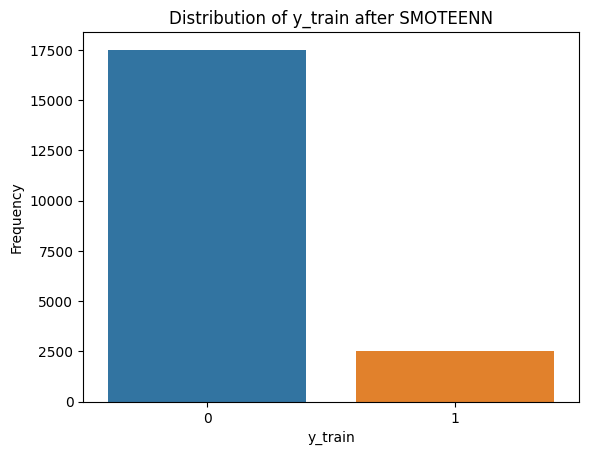

In [299]:
X = sub_df.drop("Diabetes", axis=1)
y = sub_df["Diabetes"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
joblib.dump(scaler, "scaler.pkl")

smote_enn = SMOTEENN(random_state=42)
X_train, y_train = smote_enn.fit_resample(X_train, y_train)

print(f"Resampled class distribution: {dict(zip(*np.unique(y_train, return_counts=True)))}")
sns.countplot(x=y_train)
plt.xlabel('y_train')
plt.ylabel('Frequency')
plt.title('Distribution of y_train after SMOTEENN')
plt.show()

## Model Definition

In [301]:
model = Sequential([
    Dense(128, activation="selu", input_shape=(X_train.shape[1],),),
    Dropout(0.2),
    BatchNormalization(),
    Dense(64, activation="selu"),
    Dropout(0.3),
    Dense(32, activation="selu"),
    Dense(1, activation="sigmoid")
])

# Compile model
model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy", AUC(name="auc")]
)
model.summary()

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_33"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_108 (Dense)               │ (None, 128)            │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_29 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_109 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_30 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_110 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_111 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,545 (49.00 KB)

 Trainable params: 12,289 (48.00 KB)

 Non-trainable params: 256 (1.00 KB)

In [302]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.1, callbacks=[early_stop], class_weight={0: 1, 1: 10})
model.save('../../models/diabetes_model.keras')

# Evaluate
loss, accuracy, auc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.2f}")
print(f"Test AUC: {auc:.2f}")

Epoch 1/100
563/563 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8467 - auc: 0.8530 - loss: 0.5486 - val_accuracy: 0.5330 - val_auc: 0.0000e+00 - val_loss: 0.8575
Epoch 2/100
563/563 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8957 - auc: 0.9244 - loss: 0.3612 - val_accuracy: 0.4286 - val_auc: 0.0000e+00 - val_loss: 0.9934
Epoch 3/100
563/563 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8986 - auc: 0.9207 - loss: 0.3537 - val_accuracy: 0.8167 - val_auc: 0.0000e+00 - val_loss: 0.4687
Epoch 4/100
563/563 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8814 - auc: 0.9275 - loss: 0.3287 - val_accuracy: 0.7148 - val_auc: 0.0000e+00 - val_loss: 0.6909
Epoch 5/100
563/563 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8864 - auc: 0.9237 - loss: 0.3162 - val_accuracy: 0.8242 - val_auc: 0.0000e+00 - val_loss: 0.5650
Epoch 6/100
563/563 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8862 - auc: 0.9285 - loss: 0.3200 - val_accuracy: 0.9326 - val_auc: 0.0000e+00 - val_loss: 0.3864
Epoch 7/10

In [303]:
y_pred_prob = model.predict(X_test)
y_pred_class = np.round(y_pred_prob)
roc_auc = roc_auc_score(y_test, y_pred_prob)
print(f"AUC-ROC: {roc_auc:.2f}")
print(classification_report(y_test, y_pred_class))


169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 672us/step
AUC-ROC: 0.80
              precision    recall  f1-score   support

           0       0.98      0.74      0.85      5081
           1       0.15      0.74      0.24       303

    accuracy                           0.74      5384
   macro avg       0.56      0.74      0.54      5384
weighted avg       0.93      0.74      0.81      5384

